<a href="https://colab.research.google.com/github/yifan-grace-tang/final-project/blob/main/Renee/renee's_tweaks_grace_mlcb_04_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __Protein Function Prediction Leveraging Sequence and Structure Information__

> __Author:__ Grace Tang

> __Edited:__ `04.29.25`

---


#### __Description__

Predicting the functions of proteins is an essential problem in the study of proteins. Many previous works developed computational methods that utilize protein sequence information to predict protein functions. With the advancement of `AlphaFold2`, accurate protein structure data has been available for hundreds of millions of proteins.

Incorporating structure information should be able to further boost the performance of protein function prediction methods. There are several potential ways to utilize the structure information: use computer-vision-like models to extract information from contact maps; use graph neural networks to encode 3D structures; use pretrained protein structure model (e.g., `ESM-IF`).

In addition, with the advancement of LLMs, the text annotations of proteins can also be leveraged as an extra information source for protein function prediction, e.g., use LLM as encoder to encode the text annotations of proteins. Utilizing the information from sequence, structure, and text annotations, we can develop a model that accurately predicts protein functions.

__Using a subset of the dataset used for [DeepFRI](https://github.com/flatironinstitute/DeepFRI) (a similar protein function prediction model) we aim to coallesce sequence data and structure data to predict protein function in the form of [EC Numbers](https://en.wikipedia.org/wiki/Enzyme_Commission_number).__

[[1]](ttps://www.biorxiv.org/content/10.1101/2022.11.29.518451v1), [[2]](https://www.nature.com/articles/s42003-024-07359-z), [[3]](https://www.nature.com/articles/s41467-021-23303-9), [[4]](https://www.biorxiv.org/content/10.1101/2024.05.14.594226v1 )

#### __Pre-Requisites__

While not _strictly_ neccessary - you can import your [Hugging Face](https://huggingface.co/settings/tokens/new?tokenType=read) token into your colab's secrets as `HF_TOKEN` to supress some annoying warnings.

If you would like to clear cached embeddings under `cache/` run the cell below. Note, this __shouldn't be neccessary__ unless the `ProteinDataset` feature construction changes. Under no circumstances would it be neccessary to remove the `structures/` as pulling the data from online takes quite a bit of time. __Use the next cell wisely!__

In [ ]:
# !rm -rf structures/*
# !rm -rf cache/*

In [1]:
!pip install torch-geometric &> /dev/null
!pip install transformers biopython scipy &> /dev/null

In [2]:
from google.colab import files
uploaded = files.upload()


Saving cache.zip to cache.zip
Saving annotations.tsv to annotations.tsv
Saving sequences.fasta to sequences.fasta
Saving train.txt to train.txt
Saving validation.txt to validation.txt


In [3]:
import os
import pandas as pd
import re
import numpy as np
import requests

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeometricDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.serialization import add_safe_globals
from torch_geometric.data import Data
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage

from transformers import BertTokenizer, BertModel
from Bio.PDB import MMCIFParser
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import precision_score, recall_score, f1_score

add_safe_globals([Data, DataEdgeAttr, DataTensorAttr, GlobalStorage])

#### __Data Cleaning__


> _This section relies on having_ `annotations.tsv`, `train.txt`, `validation.txt`, _and_ `sequences.fasta` _in your runtime_


We start by defining some utility functions that help parse the input data into a representation that can be fed into our downstream `Dataset` classes.

In [5]:
def parse_fasta(path):
    seqs = {}
    with open(path) as f:
        curr, lines = None, []
        for line in f:
            if line.startswith('>'):
                if curr:
                    seqs[curr] = ''.join(lines)
                curr = line[1:].split()[0]
                lines = []
            else:
                lines.append(line.strip())
        if curr:
            seqs[curr] = ''.join(lines)
    return seqs

def parse_annotations(path):
    ann_map, all_ec = {}, set()
    with open(path) as f:
        for ln in f:
            if ln.startswith('### PDB-chain'):
                break
        for ln in f:
            if not ln.strip() or ln.startswith('#'): continue
            pid, ecs = ln.strip().split('\t')
            ec_list = [e.strip() for e in ecs.split(',') if e.strip()]
            ann_map[pid] = ec_list
            all_ec.update(ec_list)
    classes = sorted(all_ec)
    return ann_map, classes

def fetch_cif(pdb_chain, out_dir="structures"):
    pdb_id, chain = pdb_chain.split('-')
    os.makedirs(out_dir, exist_ok=True)
    local_path = os.path.join(out_dir, f"{pdb_chain}.cif")
    if not os.path.exists(local_path):
        url = f"https://files.rcsb.org/download/{pdb_id}.cif"
        resp = requests.get(url)
        resp.raise_for_status()

        with open(local_path, "wb") as f:
            f.write(resp.content)
    return local_path

def build_df(ids, seqs, ann_map, classes):
    rows = []
    for pid in ids:
        seq = seqs.get(pid, '')
        if not seq:
            print(f"Warning: {pid} not found in fasta")
            continue

        ecs = ann_map.get(pid)
        if ecs is None or len(ecs)!=1:
            continue

        ec = ecs[0]
        if ec not in classes:
            continue

        label_idx = classes.index(ec)
        rows.append({
            'id'      : pid,
            'sequence': seq,
            'label'   : label_idx
        })

    return pd.DataFrame(rows)

Predicting multiple `EC` labels for a particular protein is a _hard_ problem, therefore for model performance while maintaining utility we have refined the problem space down to building a model that can predict the first three "`EC`-snippets" for a particular protein.

Additionally, to avoid multi-class classification we remove any training/validation data points that contain multiple three-level `EC` classifications. Below demonstrates the process:

In [6]:
ann_map, _ = parse_annotations('annotations.tsv')

filtered_map = {}

for pid, labels in ann_map.items():
  filtered = { ".".join(ec.split(".")[:3]) for ec in labels }
  if len(filtered) == 1:
    filtered_map[pid] = [ filtered.pop() ]

print(f"Original: {len(ann_map)}")
print(f"Filtered: {len(filtered_map)}")

Original: 19201
Filtered: 18136


Next we read the `ids` from the `train.txt` and `validation.txt` to perform our _splitting_ into a train and validation dataset with slight modifications for the trimmed `EC` classes:
- `TRAINING_DATA_SIZE` defines how many datapoints from `train.txt` are used for model training.
- `VALIDATION_RATIO` defines how many datapoints from `validation.txt` are used for model evaluation (as a fraction of `TRAINING_DATA_SIZE`)


In [7]:
TRAINING_DATA_SIZE = 2000
VALIDATION_RATIO   = 0.2

VALIDATION_DATA_SIZE = int(TRAINING_DATA_SIZE * VALIDATION_RATIO)

train_ids = [l.strip() for l in open('train.txt') if l.strip() if l.strip() in filtered_map][:TRAINING_DATA_SIZE]
val_ids   = [l.strip() for l in open('validation.txt') if l.strip() if l.strip() in filtered_map][:VALIDATION_DATA_SIZE]

classes = sorted(ecs[0] for ecs in filtered_map.values())

seqs_map = parse_fasta('sequences.fasta')

df_train = build_df(train_ids, seqs_map, filtered_map, classes)
df_val   = build_df(val_ids, seqs_map, filtered_map, classes)

#### __The `ProteinDataset`__

This `Dataset` class feeds each protein through two parallel pipelines — sequence and structure — and returns a single `torch_geometric.data.Data` object per example for graph‐based training.

1. **Structure Fetching:** Given an ID like `4PR3-A`, it downloads the corresponding `mmCIF` file from `RCSB` if not already cached. Uses Biopython’s `PDBParser` to extract all Cα atom coordinates for the specified chain.

2. **Graph Construction:** Builds an undirected residue‐level graph by connecting any two Cα atoms within 8 Å.  Encodes edge weights as the inverse distance (`1/d`) to reflect spatial proximity.

3. **Node Features:** Represents each residue by a 20‐dimensional one-hot vector (one position per standard amino acid). Ensures that non-standard letters (U, Z, O, B) are mapped to “X” and treated uniformly.

4. **`ProtBert` Embedding** Cleans and “space-separates” the amino-acid string for `Rostlab/prot_bert`.  Tokenizes, pads/truncates, and runs the model in `eval()` mode to get the last hidden states.  Applies mean-pooling (masking out padding) to produce a fixed‐size (1024-dim) global embedding.

5. **Label Vector:** Builds a multi-hot target vector for all EC classes based on `annotations.tsv`.

6. **Output**  
   - Returns a `Data` object with fields:  
     - `x`: `[L, 20]` residue features  
     - `edge_index`: `[2, E]` graph connectivity  
     - `edge_attr`: `[E, 1]` distance weights  
     - `seq_emb`: `[1024]` `ProtBert` fingerprint  
     - `y`: `[num_ec]` multi-hot EC labels  


In [8]:
class ProteinDataset(Dataset):
    AA       = "ACDEFGHIKLMNPQRSTVWY"
    AA2IDX   = {a:i for i,a in enumerate(AA)}

    def __init__(
        self,
        df,
        max_length=512,
        device=None,
        ca_cutoff=8.0,
        pdb_dir="structures",
        bert_model="Rostlab/prot_bert",
    ):
        self.df         = df.reset_index(drop=True)
        self.max_length = max_length
        self.device     = device or torch.device("cpu")
        self.ca_cutoff  = ca_cutoff
        self.pdb_dir    = pdb_dir
        os.makedirs(pdb_dir, exist_ok=True)

        self.parser    = MMCIFParser(QUIET=True)
        self.tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=False)
        self.bert      = BertModel.from_pretrained(bert_model).eval().to(self.device)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        cache_path = f"cache/{idx}.pt"

        if os.path.exists(cache_path):
            return torch.load(cache_path)

        row    = self.df.iloc[idx]
        pid    = row["id"]
        seq    = row["sequence"]
        label  = torch.tensor(int(row["label"]), dtype=torch.long)

        cif_path  = fetch_cif(pid, out_dir=self.pdb_dir)
        structure = self.parser.get_structure(pid, cif_path)

        coords = [
            (int(res.get_id()[1]), atom.get_coord())
            for model in structure
            for chain in model
            for res in chain
            for atom in res
            if atom.get_id() == "CA"
        ]
        coords.sort(key=lambda x: x[0])

        clean = re.sub(r"[^ACDEFGHIKLMNPQRSTVWY]", "X", seq.upper())
        feats = []
        for aa in clean:
            vec = torch.zeros(len(self.AA))
            vec[self.AA2IDX.get(aa, 0)] = 1.0
            feats.append(vec)
        x = torch.stack(feats, dim=0)

        positions = [resi-1 for resi, _ in coords]

        ca = torch.tensor([c for _, c in coords], dtype=torch.float)
        D  = torch.tensor(squareform(pdist(ca.numpy())), dtype=torch.float)

        row, col = (D <= self.ca_cutoff).nonzero().t()

        edge_index = torch.tensor([
            [positions[r] for r in row],
            [positions[c] for c in col]
        ], dtype=torch.long)

        edge_attr = (1.0 / (D[row, col] + 1e-8)).unsqueeze(1)

        tokens = self.tokenizer(
            " ".join(clean),
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_length
        ).to(self.device)

        with torch.no_grad():
            out = self.bert(**tokens).last_hidden_state

        mask    = tokens["attention_mask"].unsqueeze(-1)
        seq_emb = (out * mask).sum(1) / mask.sum(1)
        seq_emb = seq_emb.squeeze(0).cpu()

        data = Data(
            x          = x,
            edge_index = edge_index,
            edge_attr  = edge_attr,
            seq_emb    = seq_emb,
            y          = label
        )

        os.makedirs("cache", exist_ok=True)
        torch.save(data, cache_path)
        return data


Using our `Dataset` class now we can input our training and validation data and define some `DataLoaders` to be used by our chosen model.

In [9]:
train_ds = ProteinDataset(df_train,  device=torch.device('cuda'))
val_ds   = ProteinDataset(df_val,    device=torch.device('cuda'))

train_loader = GeometricDataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = GeometricDataLoader(val_ds,   batch_size=16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

#### __The `ConvClassifier`__

This `ConvClassifer` ingests the `Data` objects produced by `ProteinDataset` and fuses structure and sequence information to predict an EC number.

1. **Structure Branch (GCN)**  
   - **`GCNConv(20 → 128)`** + `ReLU`
   - **`GCNConv(128 → 128)`** + `ReLU`  
   - **Global Mean Pooling** over residues → a `128`-dim graph embedding

2. **Sequence Branch (MLP)**  
   - **`Linear(1024 → 128)`** + `ReLU`  
   - Takes the `ProtBert` pooled embedding and projects it down to `128` dims

3. **Fusion**  
   - **Concatenate** the `128`-dim GCN output and `128`-dim MLP output → `256`-dim vector  
   - **MLP Head**: `Linear(256 → 256)` + `ReLU` + `Dropout(0.1)` + `Linear(256 → num_ec)`  


In [10]:
class ConvClassifier(nn.Module):
    def __init__(self, seq_emb_dim, node_feat_dim, gcn_hidden, num_classes):
        super().__init__()
        self.seq_mlp = nn.Sequential(
            nn.Linear(seq_emb_dim, gcn_hidden),
            nn.ReLU()
        )

        self.conv1 = GCNConv(node_feat_dim, gcn_hidden)
        self.conv2 = GCNConv(gcn_hidden,      gcn_hidden)

        self.classifier = nn.Sequential(
            nn.Linear(2 * gcn_hidden, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = (
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        edge_index = edge_index.clamp(0, x.size(0) - 1)

        h = self.conv1(x, edge_index, edge_weight=edge_attr.squeeze())
        h = torch.relu(h)
        h = self.conv2(h, edge_index, edge_weight=edge_attr.squeeze())
        h = torch.relu(h)
        gcn_emb = global_mean_pool(h, batch)

        seq_emb_raw = data.seq_emb
        B = gcn_emb.size(0)
        seq_emb = seq_emb_raw.view(B, -1).to(gcn_emb.device)

        seq_emb = self.seq_mlp(seq_emb)

        comb = torch.cat([gcn_emb, seq_emb], dim=1)
        return self.classifier(comb)


In [24]:
sample    = train_ds[0]
seq_dim   = sample.seq_emb.shape[0]
node_dim  = sample.x.shape[1]

model = ConvClassifier(seq_emb_dim=seq_dim,
                      node_feat_dim=node_dim,
                      gcn_hidden=128,
                      num_classes=len(classes)).to(torch.device('cuda'))

#### __Model Training__

We train the classifier for `10` epochs. In each epoch the model alternates between:

1. **Training Phase**  
   - Switch to `model.train()`  
   - Iterate over `train_loader`, compute **CrossEntropyLoss** between logits and integer class labels  
   - Backpropagate with **AdamW** and accumulate the total loss  
   - Report **average training loss** at epoch end

2. **Validation Phase**  
   - Switch to `model.eval()` and disable gradients  
   - Iterate over `val_loader`, run a forward pass and take `argmax` over logits  
   - Collect predictions and targets, then compute **Accuracy**, **Precision**, **Recall** and **F₁** (micro)


In [26]:
EPOCHS = 50
LEARNING_RATE = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt   = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
crit  = nn.CrossEntropyLoss()

header = f"| {'Epoch':>5s} | {'Train Loss':>10s} | {'Val Acc':>8s} | {'Prec':>6s} | {'Rec':>6s} | {'F1':>6s} |"
print(header)
print('-' * len(header))

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        logits = model(batch)
        labels = batch.y
        loss   = crit(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * batch.num_graphs
    train_loss = total_loss / len(train_ds)
    train_losses.append(train_loss)

    model.eval()
    all_preds, all_targs = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch  = batch.to(device)
            logits = model(batch).cpu()
            preds  = logits.argmax(dim=1)
            targs  = batch.y.cpu()
            all_preds.append(preds)
            all_targs.append(targs)
            val_loss += loss.item() * batch.num_graphs

    val_loss /= len(val_ds)
    val_losses.append(val_loss)

    preds = torch.cat(all_preds).numpy()
    targs = torch.cat(all_targs).numpy()

    val_acc = (preds == targs).mean()
    p       = precision_score(targs, preds, average='macro', zero_division=0)
    r       = recall_score (targs, preds, average='macro', zero_division=0)
    f1      = f1_score     (targs, preds, average='macro', zero_division=0)

    print(
        f"{epoch:5d} | "
        f"{train_loss:10.4f} | "
        f"{val_acc*100:7.2f}% | "
        f"{p*100:6.2f}% | "
        f"{r*100:6.2f}% | "
        f"{f1*100:6.2f}%"
    )

| Epoch | Train Loss |  Val Acc |   Prec |    Rec |     F1 |
------------------------------------------------------------
    1 |     4.5590 |   10.75% |   0.56% |   2.04% |   0.71%
    2 |     4.2410 |   15.00% |   1.73% |   3.24% |   1.38%
    3 |     4.0079 |   15.00% |   0.81% |   3.25% |   1.28%
    4 |     3.8402 |   15.50% |   0.86% |   3.50% |   1.36%
    5 |     3.7161 |   18.00% |   2.44% |   5.25% |   2.96%
    6 |     3.5891 |   21.00% |   3.77% |   6.78% |   4.02%
    7 |     3.4607 |   24.00% |   6.47% |   8.45% |   6.19%
    8 |     3.3235 |   28.50% |   9.54% |  11.78% |   9.20%
    9 |     3.1727 |   29.25% |  11.86% |  13.09% |  10.54%
   10 |     3.0334 |   32.00% |  14.46% |  15.72% |  13.04%
   11 |     2.8985 |   37.00% |  18.61% |  19.78% |  17.55%
   12 |     2.7917 |   40.50% |  20.70% |  22.19% |  18.64%
   13 |     2.6340 |   42.25% |  24.64% |  23.66% |  21.85%
   14 |     2.5354 |   43.75% |  27.56% |  25.49% |  23.89%
   15 |     2.4218 |   48.50% |  25.06

#### __Model Validation__

**We are visualizing which EC numbers the model will have a higher tendency to confuse:**

Plotting Loss over Epochs to demonstrate how well the model is learning:

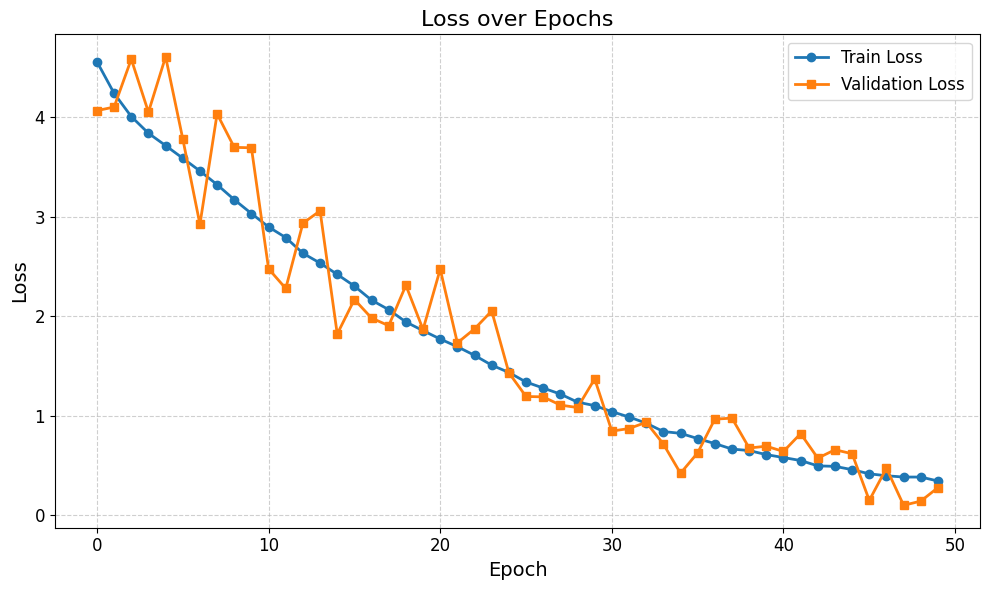

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", linewidth=2, marker='o')
plt.plot(val_losses, label="Validation Loss", linewidth=2, marker='s')

plt.title("Loss over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


The plot below visualizes the model's confidence in its prediction across all of the validation proteins.

Black bars indicate correct predictions and red bars indicate incorrect ones:

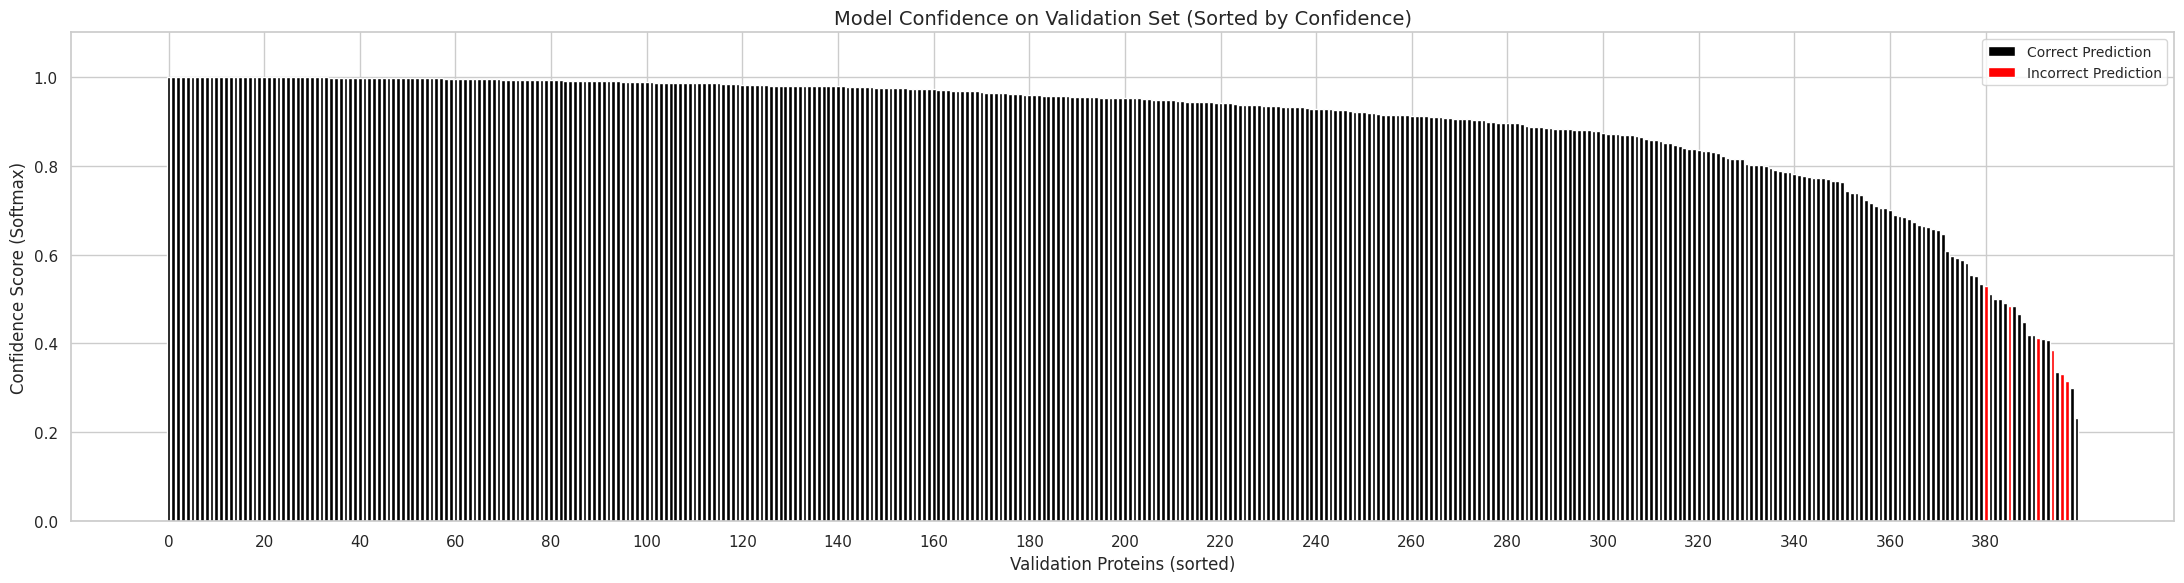

In [74]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

all_examples = sorted(all_examples, key=lambda x: x['conf'], reverse=True)
confidences = [ex['conf'] for ex in all_examples]
colors = ['black' if ex['true'] == ex['pred'] else 'red' for ex in all_examples]

plt.figure(figsize=(22, 6))
plt.bar(range(len(all_examples)), confidences, color=colors)

xtick_positions = list(range(0, len(all_examples), 20))
plt.xticks(xtick_positions)

legend_elements = [
    Patch(facecolor='black', label='Correct Prediction'),
    Patch(facecolor='red', label='Incorrect Prediction')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.ylim(0, 1.1)
plt.title("Model Confidence on Validation Set (Sorted by Confidence)", fontsize=14)
plt.ylabel("Confidence Score (Softmax)", fontsize=12)
plt.xlabel("Validation Proteins (sorted)", fontsize=12)
plt.tight_layout()
plt.show()



Printing total incorrect predictions below:

In [32]:
wrong_preds = [ex for ex in examples if ex["true"] != ex["pred"]]
print(f"Incorrect Predictions: {len(wrong_preds)} / {len(examples)}")


Incorrect Predictions: 6 / 400


In [34]:
for ex in wrong_preds:
    print(f"True: {ex['true']} | Pred: {ex['pred']} | Conf: {ex['conf']:.2f}")


True: 11382 | Pred: 13699 | Conf: 0.41
True: 6535 | Pred: 6849 | Conf: 0.49
True: 11382 | Pred: 1076 | Conf: 0.33
True: 3748 | Pred: 14789 | Conf: 0.39
True: 15784 | Pred: 6091 | Conf: 0.53
True: 2635 | Pred: 1076 | Conf: 0.32


We also plotted how confident the model was in wrong predictions, below is a plot, sorted by most to least confident wrong predictions:


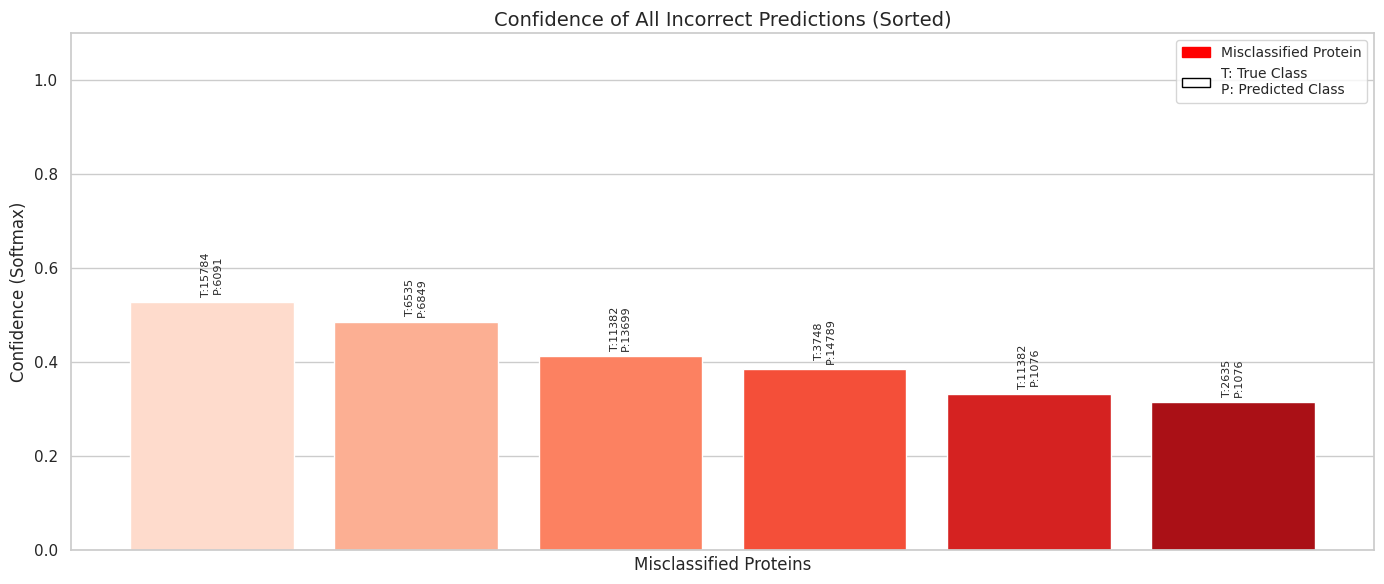

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

wrong_sorted = sorted(wrong_preds, key=lambda x: x['conf'], reverse=True)
confidences = [ex['conf'] for ex in wrong_sorted]
labels = [f"T:{ex['true']}\nP:{ex['pred']}" for ex in wrong_sorted]

sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

colors = sns.color_palette("Reds", len(wrong_sorted))
bars = plt.bar(range(len(wrong_sorted)), confidences, color=colors)

for i, ex in enumerate(wrong_sorted):
    plt.text(i, ex['conf'] + 0.015, labels[i], ha='center', fontsize=8, rotation=90)

legend_elements = [Patch(color='red', label='Misclassified Protein'),
                   Patch(facecolor='white', edgecolor='black', label='T: True Class\nP: Predicted Class')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.ylim(0, 1.1)
plt.title("Confidence of All Incorrect Predictions (Sorted)", fontsize=14)
plt.ylabel("Confidence (Softmax)", fontsize=12)
plt.xlabel("Misclassified Proteins", fontsize=12)
plt.xticks([])
plt.tight_layout()
plt.show()



#### __Cleanup__

For faster processing in the future we download the `structures/` and `cache/` directories as `zip` archives that can be unzipped in a development environment for faster future environment.

Note, that any changes to the `ProteinDataset` class will require a deletion of the `cache/` whereas the `structures/` cache should __never__ have to be recomputed.

In [ ]:
!zip -r structures.zip structures &> /dev/null
!zip -r cache.zip cache &> /dev/null

In [45]:
!torch.save(model.state_dict(), "final_model.pt")


In [46]:
!model.load_state_dict(torch.load("final_model.pt"))
!model.eval()


ConvClassifier(
  (seq_mlp): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
  )
  (conv1): GCNConv(20, 128)
  (conv2): GCNConv(128, 128)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=18136, bias=True)
  )
)